In [1]:
from atl_module import GebcoUpscaler
import pandas as pd
from sklearn.metrics import mean_squared_error

In [2]:
%cd ..

/mnt/c/Users/XCB/OneDrive - Van Oord/Documents/thesis/code


In [3]:
sitename = 'florida_keys'
site = GebcoUpscaler(sitename,
                     f'../data/test_sites/{sitename}/in-situ-DEM/truth.vrt'
                    )

In [4]:
# site.plot_lidar_error()

In [5]:
# site.download_ATL03()

In [6]:
# site.recalc_tracklines_gdf()

In [7]:
# from itertools import product
# # setup result dictionary
# result = {}
# # make an empty list for each result
# result['window']=[]
# result['perc_hconf']=[]
# result['min_kde']=[]
# result['rmse']=[]
# result['MAE']=[]

# # loop over the inner product of the 
# for window,perc_h,kde_min in product([100,150,200],[20,40,60],[0.0,0.1,0.2]):
#     result['window'].append(window)
#     result['perc_hconf'].append(perc_h)
#     result['min_kde'].append(kde_min)
#     site.find_bathy_from_icesat(
#     window=window,
#     threshold_val=0.0,
#     req_perc_hconf=perc_h,
#     window_meters=None,
#     min_photons=None,
#     min_kde=kde_min,
#     save_result=False
#     )
#     site.lidar_rmse()
#     result['rmse'].append(site.rmse_icesat)
#     result['MAE'].append(site.mae_icesat)
#     print(result)

# pd.DataFrame(result).to_csv(f'../data/test_sites/{site.site}/error_stats.csv')

In [8]:
site.find_bathy_from_icesat(
    window=200,
    threshold_val=0.0,
    req_perc_hconf=60,
    window_meters=None,
    min_photons=None,
    min_kde=0.0,
    # low_limit=-40,
    # high_limit=2,
    # rolling_window=200,
    # max_sea_surf_elev=1000,
    # filter_below_z=-40,
    # filter_below_depth=-40,
    # n=1,
    # level=5,
)
site.add_truth_data()
site.lidar_error()
site.subset_gebco(hres=50)

[I 220803 17:40:21 core:126] site: Florida_keys - Starting bathymetry signal finding with parameters: {'window_size_photons': 200, 'threshhold value': 0.0, 'Required percentage high confidence ocean photons': 60, 'minimum photons in distance window': None, 'window_horizontal': None, 'Minimum KDE to be considered': 0.0}
[I 220803 17:43:03 core:204] Truth data added to Bathymetric Points dataframe for site: Florida_keys
/home/mlinds/mambaforge/envs/thesis_env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
[I 220803 17:44:19 core:146] The bathymetry for Florida_keys was sucessfully calculated with {'window_size_photons': 200, 'threshhold value': 0.0, 'Required percentage high confidence ocean photons': 60, 'minimum photons in distance window': None, 'window_horizontal': None, 'Minimum KDE to be considered': 0.0} an

,MAE,RMSE
Florida_keys,0.463141,0.568329


[I 220803 17:47:29 core:256] Florida_keys: Saved lidar error plot to ../document/figures/Florida_keys_lidar_estimated_vs_truth.jpg


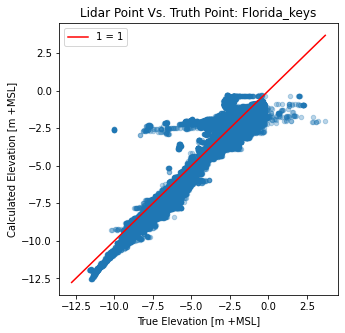

In [13]:
site.plot_lidar_error()

In [10]:
# site.bathy_pts_gdf = site.bathy_pts_gdf.assign(z_kde = site.bathy_pts_gdf.z_kde - site.bathy_pts_gdf.dac_corr  + site.bathy_pts_gdf.tide_ocean_corr)

In [11]:
# %%time
# site.kriging(
#     npts=2000,
#     kr_model = 'ok',
#     samplemethod='dart',
#     variogram_parameters={'range':33000,'nugget':0.7,'sill':23},

# )

In [12]:
site.kalman_update(0.75)
site.raster_rmse(error_out=True)

ValueError: operands could not be broadcast together with shapes (189,386) (531,606) 

In [ ]:
date_indexed_tracklines  = site.tracklines.assign(date = pd.to_datetime(site.tracklines.date).dt.date).reset_index().set_index(['date','beam'])
df = site.bathy_pts_gdf.eval('error=z_kde-true_elevation').eval('error_abs=abs(z_kde-true_elevation)').groupby([pd.to_datetime(site.bathy_pts_gdf.rename(columns={'delta_time':'date'}).date).dt.date,'beam']).mean().sort_values('error',ascending=False)
# 
df = df.merge(date_indexed_tracklines,how='left',left_index=True,right_index=True)


In [ ]:
site.bathy_pts_gdf.eval('error=z_kde-true_elevation').plot.scatter(x='error',y='sea_level_interp')

In [ ]:
site.bathy_pts_gdf.eval('error=(z_kde-true_elevation)').plot.scatter(x='error',y='kde_val')

In [ ]:
df.plot.scatter(y='error',x='oc_sig_conf')

In [ ]:
df.plot.scatter(y='error',x='oc_hconf_perc')

In [ ]:
df.plot.scatter(y='error_abs',x='secchi_depth')

In [ ]:
df.plot.scatter(y='error_abs',x='tide_ocean_corr')

In [ ]:
df.plot.scatter(y='error_abs',x='dac_corr')

In [ ]:
df.plot.scatter(y='error_abs',x='kde_val')

In [ ]:
df.plot.scatter(y='error_abs',x='sea_level_interp')

In [ ]:
site.bathy_pts_gdf.eval('error=z_kde-true_elevation').corr()['error'].sort_values()

In [ ]:
df.corr()['error'].sort_values()

In [ ]:
site.bathy_pts_gdf[site.bathy_pts_gdf.Z_geoid>-50].dropna().eval('error=(z_kde-true_elevation)**2').error.mean()**(0.5)

In [ ]:
site.bathy_pts_gdf.eval('error=z_kde-true_elevation').error.mean()

In [ ]:
dac_tide = site.bathy_pts_gdf.z_kde  - site.bathy_pts_gdf.dac_corr  + site.bathy_pts_gdf.tide_ocean_corr
site.bathy_pts_gdf.assign(dac_tide=dac_tide).eval('error=(dac_tide-true_elevation)**2').error.mean()**(0.5)

In [ ]:
site.bathy_pts_gdf.assign(dac_tide=dac_tide).eval('error=dac_tide-true_elevation').error.mean()

In [ ]:
site.bathy_pts_gdf[site.bathy_pts_gdf.Z_geoid>-50].sea_level_interp

## 

In [ ]:
site.bathy_pts_gdf.count()

In [ ]:
df